In [1]:
import pandas as pd
import numpy as np
import prettytable
from matplotlib import pyplot as plt
from dataPretreatment.dataEncoder import labelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt  # 画图工具
from sklearn import tree, linear_model  # 树、线性模型
from sklearn.model_selection import train_test_split # 数据切割
from sklearn.model_selection import GridSearchCV  # 网格搜索
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, \
    roc_auc_score  # 分类指标库
from sklearn.ensemble import RandomForestClassifier  # 随机森林
sns.set(style='whitegrid')

In [2]:
# read dataset
df_039 = pd.read_csv('dataset/dataset_039.csv')
df_110 = pd.read_csv('dataset/dataset_110.csv')
df_173 = pd.read_csv('dataset/dataset_173.csv')
df_196 = pd.read_csv('dataset/dataset_196.csv')

In [3]:
# classified columns
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_columns = ['job','marital','education','default','housing','loan','contact','month','poutcome','y']
columns = numeric_columns + categorical_columns

In [4]:
# one-hot label coding
df_039 = labelEncoder.labelEncoder(df_039,labels=categorical_columns)
df_110 = labelEncoder.labelEncoder(df_110, labels=categorical_columns)
df_173 = labelEncoder.labelEncoder(df_173, labels=categorical_columns)
df_196 = labelEncoder.labelEncoder(df_196, labels=categorical_columns)

Column 'job': ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown'] : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Column 'marital': ['divorced', 'married', 'single'] : [0 1 2]
Column 'education': ['primary', 'secondary', 'tertiary', 'unknown'] : [0 1 2 3]
Column 'default': ['no', 'yes'] : [0 1]
Column 'housing': ['no', 'yes'] : [0 1]
Column 'loan': ['no', 'yes'] : [0 1]
Column 'contact': ['cellular', 'telephone', 'unknown'] : [0 1 2]
Column 'month': ['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep'] : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Column 'poutcome': ['failure', 'other', 'success', 'unknown'] : [0 1 2 3]
Column 'y': ['no', 'yes'] : [0 1]
Column 'job': ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown'] : [ 0  1  2  3  4  5  6  7  8  9 10 11]
C

In [5]:
# Splitting the data set into a training and test set
df_039_X = df_039.iloc[:, 0:-1]
df_039_y = df_039.iloc[:, -1]
df_039_X_train, df_039_X_test, df_039_y_train, df_039_y_test = train_test_split(df_039_X, df_039_y, test_size=0.25, random_state=0)
print( f'The length of training data and test data are {len(df_039_X_train)} and {len(df_039_X_test)}')

The length of training data and test data are 12295 and 4099


In [10]:
# Optimal parameters: {'max_depth': 18, 'max_features': 7, 'n_estimators': 90}
print('{:-^60}'.format('Random forest construction'))
# sample and features
n_samples, n_features = df_039_X_train.shape
print('{:-^60}'.format('data check'))
print('The number of data: {0} | The number of features: {1}'.format(n_samples, n_features))

# using the grid-search to find the optimal model
model_RF = RandomForestClassifier(random_state=0,class_weight='balanced',criterion='gini')
parameters = {'n_estimators': range(10, 100, 10),
              'max_depth': range(2, 20, 2),
             #'min_samples_split': range(10, 500, 20),
              'max_features': range(2, 16, 2)
              }
parameters = {'n_estimators': [90],
              'max_depth': [18],
              # 'min_samples_split': range(10, 500, 20),
              'max_features': [7]
              }
# use the grid-search and cross-validation to train the model
model_gs = GridSearchCV(estimator=model_RF, param_grid=parameters, cv=10, n_jobs=-1,scoring='roc_auc')
model_gs.fit(df_039_X_train, df_039_y_train)
print('Optimal score:', model_gs.best_score_)
print('Optimal parameters:', model_gs.best_params_)
df_039_model_rf = model_gs.best_estimator_
# use the optimal parameters to fit the model
df_039_model_rf.fit(df_039_X_train, df_039_y_train)
y_predict = df_039_model_rf.predict(df_039_X_test)
y_score = df_039_model_rf.predict_proba(df_039_X_test)
print(df_039_X_train.columns)
# evaluate the model
fpr, tpr, thresholds = roc_curve(df_039_y_test, y_score[:, 1])  # auc
accuracy = metrics.accuracy_score(df_039_y_test, y_predict) # 精度
confusionmatrix = metrics.confusion_matrix(df_039_y_test, y_predict) # 混淆矩阵
target_names = ['class 0', 'class 1'] # 两个类别
classifyreport = metrics.classification_report(df_039_y_test, y_predict,target_names=target_names) # 分类结果报告
print('分类准确率 ',accuracy) # 混淆矩阵对角线元素之和/所有元素之和
print('混淆矩阵 \n', confusionmatrix)
print('分类结果报告 \n', classifyreport)
# 核心评估指标：accuracy，precision，recall，f1分数
accuracy_s = accuracy_score(df_039_y_test, y_predict).round(3)  # 准确率
precision_s = precision_score(df_039_y_test, y_predict).round(3)  # 精确度
recall_s = recall_score(df_039_y_test, y_predict).round(3)  # 召回率
f1_s = f1_score(df_039_y_test, y_predict).round(3)  # F1得分
core_metrics = prettytable.PrettyTable()  # 创建表格实例
auc_s = auc(fpr, tpr).round(3)  # AUC
core_metrics.field_names = ['auc','accuracy', 'precision', 'recall', 'f1']  # 定义表格列名
core_metrics.add_row([auc_s, accuracy_s, precision_s, recall_s, f1_s])  # 增加数据
print('{:-^60}'.format('核心评估指标'), '\n', core_metrics)

-----------------Random forest construction-----------------
-------------------------data check-------------------------
The number of data: 12295 | The number of features: 16
Optimal score: 0.9175578726107798
Optimal parameters: {'max_depth': 18, 'max_features': 7, 'n_estimators': 90}
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')
分类准确率  0.8965601366186875
混淆矩阵 
 [[3459  130]
 [ 294  216]]
分类结果报告 
               precision    recall  f1-score   support

     class 0       0.92      0.96      0.94      3589
     class 1       0.62      0.42      0.50       510

    accuracy                           0.90      4099
   macro avg       0.77      0.69      0.72      4099
weighted avg       0.88      0.90      0.89      4099

---------------------------核心评估指标--------------------------- 
 +-------+----------+-----------+--------+-----

In [11]:
# Splitting the data set into a training and test set
df_110_X = df_110.iloc[:, 0:-1]
df_110_y = df_110.iloc[:, -1]
df_110_X_train, df_110_X_test, df_110_y_train, df_110_y_test = train_test_split(df_110_X, df_110_y, test_size=0.25, random_state=0)
print( f'The length of training data and test data are {len(df_110_X_train)} and {len(df_110_X_test)}')

The length of training data and test data are 12415 and 4139


In [15]:
# Optimal parameters: {'max_depth': 16, 'max_features': 5, 'n_estimators': 90}
print('{:-^60}'.format('Random forest construction'))
# sample and features
n_samples, n_features = df_110_X_train.shape
print('{:-^60}'.format('data check'))
print('The number of data: {0} | The number of features: {1}'.format(n_samples, n_features))

# using the grid-search to find the optimal model
model_RF = RandomForestClassifier(random_state=0,class_weight='balanced',criterion='gini')
parameters = {'n_estimators': range(10, 100, 10),
              'max_depth': range(2, 18, 2),
             #'min_samples_split': range(10, 500, 20),
              'max_features': range(2, 16, 2)
              }
parameters = {'n_estimators': [90],
              'max_depth': [16],
              # 'min_samples_split': range(10, 500, 20),
              'max_features': [6]
              }
# # use the grid-search and cross-validation to train the model
model_gs = GridSearchCV(estimator=model_RF, param_grid=parameters, cv=10, n_jobs=-1,scoring='roc_auc')
model_gs.fit(df_110_X_train, df_110_y_train)
print('Optimal score:', model_gs.best_score_)
print('Optimal parameters:', model_gs.best_params_)
df_110_model_rf = model_gs.best_estimator_
# use the optimal parameters to fit the model
df_110_model_rf.fit(df_110_X_train, df_110_y_train)
y_predict = df_110_model_rf.predict(df_110_X_test)
y_score = df_110_model_rf.predict_proba(df_110_X_test)
print(df_110_X_train.columns)
# evaluate the model
fpr, tpr, thresholds = roc_curve(df_110_y_test, y_score[:, 1])  # auc
accuracy = metrics.accuracy_score(df_110_y_test, y_predict) # 精度
confusionmatrix = metrics.confusion_matrix(df_110_y_test, y_predict) # 混淆矩阵
target_names = ['class 0', 'class 1'] # 两个类别
classifyreport = metrics.classification_report(df_110_y_test, y_predict,target_names=target_names) # 分类结果报告
print('分类准确率 ',accuracy) # 混淆矩阵对角线元素之和/所有元素之和
print('混淆矩阵 \n', confusionmatrix)
print('分类结果报告 \n', classifyreport)
# 核心评估指标：accuracy，precision，recall，f1分数
accuracy_s = accuracy_score(df_110_y_test, y_predict).round(3)  # 准确率
precision_s = precision_score(df_110_y_test, y_predict).round(3)  # 精确度
recall_s = recall_score(df_110_y_test, y_predict).round(3)  # 召回率
f1_s = f1_score(df_110_y_test, y_predict).round(3)  # F1得分
core_metrics = prettytable.PrettyTable()  # 创建表格实例
auc_s = auc(fpr, tpr).round(3)  # AUC
core_metrics.field_names = ['auc','accuracy', 'precision', 'recall', 'f1']  # 定义表格列名
core_metrics.add_row([auc_s, accuracy_s, precision_s, recall_s, f1_s])  # 增加数据
print('{:-^60}'.format('核心评估指标'), '\n', core_metrics)

-----------------Random forest construction-----------------
-------------------------data check-------------------------
The number of data: 12415 | The number of features: 16
Optimal score: 0.9115884407172077
Optimal parameters: {'max_depth': 16, 'max_features': 6, 'n_estimators': 90}
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')
分类准确率  0.8965933800434888
混淆矩阵 
 [[3481  164]
 [ 264  230]]
分类结果报告 
               precision    recall  f1-score   support

     class 0       0.93      0.96      0.94      3645
     class 1       0.58      0.47      0.52       494

    accuracy                           0.90      4139
   macro avg       0.76      0.71      0.73      4139
weighted avg       0.89      0.90      0.89      4139

---------------------------核心评估指标--------------------------- 
 +-------+----------+-----------+--------+-----

In [16]:
# Splitting the data set into a training and test set
df_173_X = df_173.iloc[:, 0:-1]
df_173_y = df_173.iloc[:, -1]
df_173_X_train, df_173_X_test, df_173_y_train, df_173_y_test = train_test_split(df_173_X, df_173_y, test_size=0.25, random_state=0)
print( f'The length of training data and test data are {len(df_173_X_train)} and {len(df_173_X_test)}')

The length of training data and test data are 13154 and 4385


In [21]:
# Optimal parameters: {'max_depth': 16, 'max_features': 5, 'n_estimators': 90}
print('{:-^60}'.format('Random forest construction'))
# sample and features
n_samples, n_features = df_173_X_train.shape
print('{:-^60}'.format('data check'))
print('The number of data: {0} | The number of features: {1}'.format(n_samples, n_features))

# using the grid-search to find the optimal model
model_RF = RandomForestClassifier(random_state=0,class_weight='balanced',criterion='gini')
parameters = {'n_estimators': range(10, 100, 10),
              'max_depth': range(2, 18, 2),
             #'min_samples_split': range(10, 500, 20),
              'max_features': range(2, 16, 2)
              }
parameters = {'n_estimators': [90],
              'max_depth': [16],
              # 'min_samples_split': range(10, 500, 20),
              'max_features': [4]
              }
# # use the grid-search and cross-validation to train the model
model_gs = GridSearchCV(estimator=model_RF, param_grid=parameters, cv=10, n_jobs=-1,scoring='roc_auc')
model_gs.fit(df_173_X_train, df_173_y_train)
print('Optimal score:', model_gs.best_score_)
print('Optimal parameters:', model_gs.best_params_)
df_173_model_rf = model_gs.best_estimator_
# use the optimal parameters to fit the model
df_173_model_rf.fit(df_173_X_train, df_173_y_train)
y_predict = df_173_model_rf.predict(df_173_X_test)
y_score = df_173_model_rf.predict_proba(df_173_X_test)
print(df_173_X_train.columns)
# evaluate the model
fpr, tpr, thresholds = roc_curve(df_173_y_test, y_score[:, 1])  # auc
accuracy = metrics.accuracy_score(df_173_y_test, y_predict) # 精度
confusionmatrix = metrics.confusion_matrix(df_173_y_test, y_predict) # 混淆矩阵
target_names = ['class 0', 'class 1'] # 两个类别
classifyreport = metrics.classification_report(df_173_y_test, y_predict,target_names=target_names) # 分类结果报告
print('分类准确率 ',accuracy) # 混淆矩阵对角线元素之和/所有元素之和
print('混淆矩阵 \n', confusionmatrix)
print('分类结果报告 \n', classifyreport)
# 核心评估指标：accuracy，precision，recall，f1分数
accuracy_s = accuracy_score(df_173_y_test, y_predict).round(3)  # 准确率
precision_s = precision_score(df_173_y_test, y_predict).round(3)  # 精确度
recall_s = recall_score(df_173_y_test, y_predict).round(3)  # 召回率
f1_s = f1_score(df_173_y_test, y_predict).round(3)  # F1得分
core_metrics = prettytable.PrettyTable()  # 创建表格实例
auc_s = auc(fpr, tpr).round(3)  # AUC
core_metrics.field_names = ['auc','accuracy', 'precision', 'recall', 'f1']  # 定义表格列名
core_metrics.add_row([auc_s, accuracy_s, precision_s, recall_s, f1_s])  # 增加数据
print('{:-^60}'.format('核心评估指标'), '\n', core_metrics)

-----------------Random forest construction-----------------
-------------------------data check-------------------------
The number of data: 13154 | The number of features: 16
Optimal score: 0.9144948307513852
Optimal parameters: {'max_depth': 16, 'max_features': 4, 'n_estimators': 90}
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')
分类准确率  0.8955530216647662
混淆矩阵 
 [[3692  178]
 [ 280  235]]
分类结果报告 
               precision    recall  f1-score   support

     class 0       0.93      0.95      0.94      3870
     class 1       0.57      0.46      0.51       515

    accuracy                           0.90      4385
   macro avg       0.75      0.71      0.72      4385
weighted avg       0.89      0.90      0.89      4385

---------------------------核心评估指标--------------------------- 
 +-------+----------+-----------+--------+-----

In [22]:
# Splitting the data set into a training and test set
df_196_X = df_196.iloc[:, 0:-1]
df_196_y = df_196.iloc[:, -1]
df_196_X_train, df_196_X_test, df_196_y_train, df_196_y_test = train_test_split(df_196_X, df_196_y, test_size=0.25, random_state=0)
print( f'The length of training data and test data are {len(df_196_X_train)} and {len(df_196_X_test)}')

The length of training data and test data are 9114 and 3039


In [23]:
# Optimal parameters: {'max_depth': 16, 'max_features': 5, 'n_estimators': 90}
print('{:-^60}'.format('Random forest construction'))
# sample and features
n_samples, n_features = df_196_X_train.shape
print('{:-^60}'.format('data check'))
print('The number of data: {0} | The number of features: {1}'.format(n_samples, n_features))

# using the grid-search to find the optimal model
model_RF = RandomForestClassifier(random_state=0,class_weight='balanced',criterion='gini')
parameters = {'n_estimators': range(10, 100, 10),
              'max_depth': range(2, 18, 2),
             #'min_samples_split': range(10, 500, 20),
              'max_features': range(2, 16, 2)
              }
parameters = {'n_estimators': [90],
              'max_depth': [18],
              # 'min_samples_split': range(10, 500, 20),
              'max_features': [4]
              }
# # use the grid-search and cross-validation to train the model
model_gs = GridSearchCV(estimator=model_RF, param_grid=parameters, cv=10, n_jobs=-1,scoring='roc_auc')
model_gs.fit(df_196_X_train, df_196_y_train)
print('Optimal score:', model_gs.best_score_)
print('Optimal parameters:', model_gs.best_params_)
df_196_model_rf = model_gs.best_estimator_
# use the optimal parameters to fit the model
df_196_model_rf.fit(df_196_X_train, df_196_y_train)
y_predict = df_196_model_rf.predict(df_196_X_test)
y_score = df_196_model_rf.predict_proba(df_196_X_test)
print(df_196_X_train.columns)
# evaluate the model
fpr, tpr, thresholds = roc_curve(df_196_y_test, y_score[:, 1])  # auc
accuracy = metrics.accuracy_score(df_196_y_test, y_predict) # 精度
confusionmatrix = metrics.confusion_matrix(df_196_y_test, y_predict) # 混淆矩阵
target_names = ['class 0', 'class 1'] # 两个类别
classifyreport = metrics.classification_report(df_196_y_test, y_predict,target_names=target_names) # 分类结果报告
print('分类准确率 ',accuracy) # 混淆矩阵对角线元素之和/所有元素之和
print('混淆矩阵 \n', confusionmatrix)
print('分类结果报告 \n', classifyreport)
# 核心评估指标：accuracy，precision，recall，f1分数
accuracy_s = accuracy_score(df_196_y_test, y_predict).round(3)  # 准确率
precision_s = precision_score(df_196_y_test, y_predict).round(3)  # 精确度
recall_s = recall_score(df_196_y_test, y_predict).round(3)  # 召回率
f1_s = f1_score(df_196_y_test, y_predict).round(3)  # F1得分
core_metrics = prettytable.PrettyTable()  # 创建表格实例
auc_s = auc(fpr, tpr).round(3)  # AUC
core_metrics.field_names = ['auc','accuracy', 'precision', 'recall', 'f1']  # 定义表格列名
core_metrics.add_row([auc_s, accuracy_s, precision_s, recall_s, f1_s])  # 增加数据
print('{:-^60}'.format('核心评估指标'), '\n', core_metrics)

-----------------Random forest construction-----------------
-------------------------data check-------------------------
The number of data: 9114 | The number of features: 16
Optimal score: 0.9147373329564574
Optimal parameters: {'max_depth': 18, 'max_features': 4, 'n_estimators': 90}
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')
分类准确率  0.8950312602829879
混淆矩阵 
 [[2607   66]
 [ 253  113]]
分类结果报告 
               precision    recall  f1-score   support

     class 0       0.91      0.98      0.94      2673
     class 1       0.63      0.31      0.41       366

    accuracy                           0.90      3039
   macro avg       0.77      0.64      0.68      3039
weighted avg       0.88      0.90      0.88      3039

---------------------------核心评估指标--------------------------- 
 +-------+----------+-----------+--------+------

In [24]:
df_039_lr_model_probs_test = df_039_model_rf.predict_proba(df_039_X_test)
df_110_lr_model_probs_test = df_110_model_rf.predict_proba(df_110_X_test)
df_173_lr_model_probs_test = df_173_model_rf.predict_proba(df_173_X_test)
df_196_lr_model_probs_test = df_196_model_rf.predict_proba(df_196_X_test)

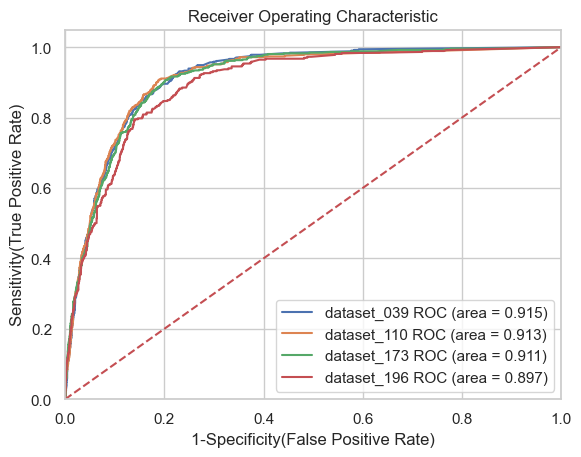

In [25]:
# Set models and probabilities. This structure is called a dictionary.
models = [
{
    'label': 'dataset_039',
    'probs': df_039_lr_model_probs_test[:,1],
    'y_ture':df_039_y_test
},
{
    'label': 'dataset_110',
    'probs': df_110_lr_model_probs_test[:,1],
    'y_ture':df_110_y_test
},
{
    'label': 'dataset_173',
    'probs': df_173_lr_model_probs_test[:,1],
    'y_ture':df_173_y_test
},
    {
    'label': 'dataset_196',
    'probs': df_196_lr_model_probs_test[:,1],
    'y_ture':df_196_y_test
}
]

# Loop that creates the plot. I will pass each ROC curve one by one.
for m in models:
  auc = roc_auc_score(y_true = m['y_ture'], 
                             y_score = m['probs'])
  fpr, tpr, thresholds = roc_curve(m['y_ture'], 
                                           m['probs'])
  plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % (m['label'], auc))
                 

    
# Settings
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Random Forest)')
plt.legend(loc="lower right")
    
# Plot!    
plt.show()

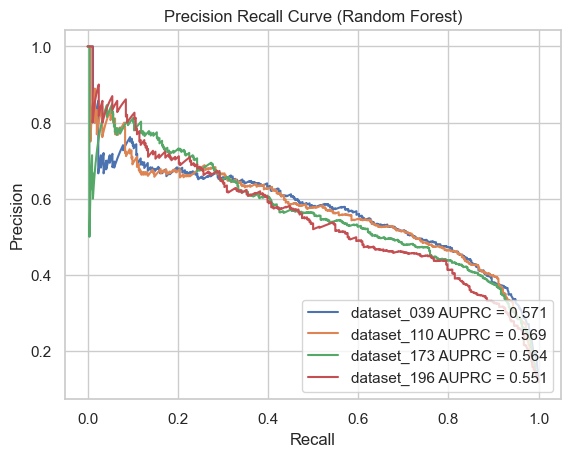

In [28]:
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import average_precision_score
# Set models and probabilities. This structure is called a dictionary.
models = [
{
    'label': 'dataset_039',
    'probs': df_039_lr_model_probs_test[:,1],
    'y_ture':df_039_y_test
},
{
    'label': 'dataset_110',
    'probs': df_110_lr_model_probs_test[:,1],
    'y_ture':df_110_y_test
},
{
    'label': 'dataset_173',
    'probs': df_173_lr_model_probs_test[:,1],
    'y_ture':df_173_y_test
},
    {
    'label': 'dataset_196',
    'probs': df_196_lr_model_probs_test[:,1],
    'y_ture':df_196_y_test
}
]

# Loop that creates the plot. I will pass each ROC curve one by one.
for m in models:
    average_precision = average_precision_score(m['y_ture'],m['probs'])

    precision, recall, thresholds = precision_recall_curve(m['y_ture'], m['probs'])

    plt.plot(recall, precision, label='%s AUPRC = %0.3f' % (m['label'], average_precision))



# Settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve (Random Forest)')
plt.legend(loc="lower right")

# Plot!
plt.show()